In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Preparar o dataset para análise
Nessa etapa é analisado o dataset e é feito a limpeza dos dados para dar sequência ao projeto.

In [2]:
df = pd.read_csv('./dataset/resumo_anual_2019.csv', delimiter=";", encoding='latin-1')

In [3]:
df.columns = ['EMPRESA_SIGLA','EMPRESA_NOME','EMPRESA_NACIONALIDADE','ANO','MES','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_ORIGEM_NOME','AEROPORTO_DE_ORIGEM_UF','AEROPORTO_DE_ORIGEM_REGIAO','AEROPORTO_DE_ORIGEM_PAIS','AEROPORTO_DE_ORIGEM_CONTINENTE','AEROPORTO_DE_DESTINO_SIGLA','AEROPORTO_DE_DESTINO_NOME','AEROPORTO_DE_DESTINO_UF','AEROPORTO_DE_DESTINO_REGIAO','AEROPORTO_DE_DESTINO_PAIS','AEROPORTO_DE_DESTINO_CONTINENTE','NATUREZA','GRUPO_DE_VOO','PASSAGEIROS_PAGOS','PASSAGEIROS_GRATIS','CARGA_PAGA_KG','CARGA_GRATIS_KG','CORREIO_KG','ASK','RPK','ATK','RTK','COMBUSTIVEL_LITROS','DISTANCIA_VOADA_KM','DECOLAGENS','CARGA_PAGA_KM','CARGA_GRATIS_KM','CORREIO_KM','ASSENTOS','PAYLOAD','HORAS_VOADAS','BAGAGEM_KG']
df['HORAS_VOADAS'] = df['HORAS_VOADAS'].str.replace(',', '.').astype(float)

In [4]:
df = df[~(df[['EMPRESA_SIGLA','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_DESTINO_SIGLA']].duplicated(keep=False)) & (df['AEROPORTO_DE_ORIGEM_SIGLA'] != df['AEROPORTO_DE_DESTINO_SIGLA'])]

In [5]:
columns = ['EMPRESA_SIGLA','EMPRESA_NOME','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_ORIGEM_NOME','AEROPORTO_DE_ORIGEM_UF','AEROPORTO_DE_DESTINO_SIGLA','AEROPORTO_DE_DESTINO_NOME','AEROPORTO_DE_DESTINO_UF','DECOLAGENS','HORAS_VOADAS']

In [6]:
df = df[columns].dropna()

In [7]:
df_routes_by_airline = df[(df['EMPRESA_SIGLA'] == 'AZU') | (df['EMPRESA_SIGLA'] == 'TAM')]

# Implementação da teoria dos grafos
Na célula seguinte é feito uma interação com o dataset para retornar todos os nós possíveis do grafo.

In [8]:
nodes = set()
source_list = set()
destiny_list = set()

for i in df_routes_by_airline['AEROPORTO_DE_ORIGEM_SIGLA'].values:
    nodes.add(i)
    source_list.add(i)
for i in df_routes_by_airline['AEROPORTO_DE_DESTINO_SIGLA'].values:
    nodes.add(i)
    destiny_list.add(i)

nodes = sorted(nodes)

### Criação da lista de Adjacências

In [9]:
adjacency_list = {}

for n in nodes:
    adjacency_list[n] = []
    for d in df_routes_by_airline[df_routes_by_airline['AEROPORTO_DE_ORIGEM_SIGLA'] == n].values:
        adjacency_list[n].append(d[5])

#### Descomente a próxima célula para visualizar a lista de adjacências.

In [10]:
#adjacency_list

### Busca em largura (BFS) para percorerr o grafo
A função backtrace retorna o caminho desde o nó origem até o nó final.

In [11]:
def backtrace(parent, source, destiny):
    path = [destiny]
    while path[-1] != source:
        path.append(parent[path[-1]])
    path.reverse()
    path_map = {}
    for i,node in enumerate(path[:-1]):
        path_map[node] = path[i+1]
        
    return path_map

In [12]:
def bfs(graph, source, destiny):
    visited = {}
    queue = []
    traversal_tree = {}
    parent = {}
    
    queue.append(source)
    visited[source] = True
    
    while(queue):
        node = queue.pop(0)
        traversal_tree[node] = []
        
        if node == destiny:
            return backtrace(parent, source, destiny),traversal_tree
        
        for v in graph[node]:
            if v not in visited.keys():
                if node not in queue:
                    visited[v] = True
                    queue.append(v)
                    
                    traversal_tree[node].append(v)
                    parent[v] = node 

#### Lista de aeroportos de origem e destino

In [13]:
print('Lista de aeroportos de origem:')
print(source_list)

print('\nLista de aeroportos de destino:')
print(destiny_list)

Lista de aeroportos de origem:
{'SBTE', 'SBDB', 'SBRF', 'SBRB', 'SBLO', 'SWLC', 'SBJP', 'SBIL', 'SBJA', 'SBTC', 'SBJU', 'SBMO', 'SBSO', 'SBCH', 'SBGL', 'SBSV', 'SBML', 'SBFZ', 'SBCN', 'SBGP', 'SBFL', 'SBBV', 'SBCT', 'SBRJ', 'SBPF', 'SNPD', 'SBCR', 'SBVT', 'SBSN', 'SDSC', 'SBAU', 'SBTD', 'SBSL', 'SBBH', 'SSKW', 'SBCA', 'SBUR', 'SBPA', 'SBMG', 'SBMA', 'SBNF', 'SBQV', 'SBDN', 'SBSM', 'SBPS', 'SBAR', 'SBBE', 'SBSR', 'SBGO', 'SBAT', 'SSZW', 'SBDO', 'SBPL', 'SBJE', 'SBSG', 'SBZM', 'SBFI', 'SBUL', 'SBEG', 'SBPG', 'SBVH', 'SBAQ', 'SBBW', 'SBRP', 'SBCX', 'SBFN', 'SBCY', 'SBJI', 'SBGR', 'SBUG', 'SBCG', 'SNAT', 'SBCP', 'SBIP', 'SBBR', 'SBGU', 'SBKP', 'SNTF', 'SBCF', 'SBIZ', 'SBPV', 'SBAE', 'SBPK', 'SBHT', 'SBCB', 'SBSJ', 'SBPJ', 'SBSP', 'SBTT', 'SBMS', 'SBMQ', 'SNBR', 'SBME', 'SBJV'}

Lista de aeroportos de destino:
{'SBTE', 'SBDB', 'SBRF', 'SBRB', 'SBLO', 'SBJP', 'SBIL', 'SBJA', 'SBTC', 'SBJU', 'SBMO', 'SBKG', 'SBCH', 'SBGL', 'SBSV', 'SBML', 'SBFZ', 'SBCN', 'SBFL', 'SBBV', 'SBCT', 'SBRJ', 'SBPF'

#### Altere as variáveis source ou destiny para visualizar outros exemplos de travessia.

In [14]:
source = 'SBPL'
destiny = 'SBUR'
path,traversal_tree = bfs(adjacency_list, source, destiny)

### Caminho percorrido
Na próxima célula mostra as células que o algoritmo passou desde o nó origem até o nó destino. E, na célula subsequente, mostra a árvore resultante pelo BFS.

In [15]:
path

{'SBPL': 'SBFZ', 'SBFZ': 'SBBR', 'SBBR': 'SBUL', 'SBUL': 'SBUR'}

In [16]:
#traversal_tree

## Visualização do grafo
### Grafo completo

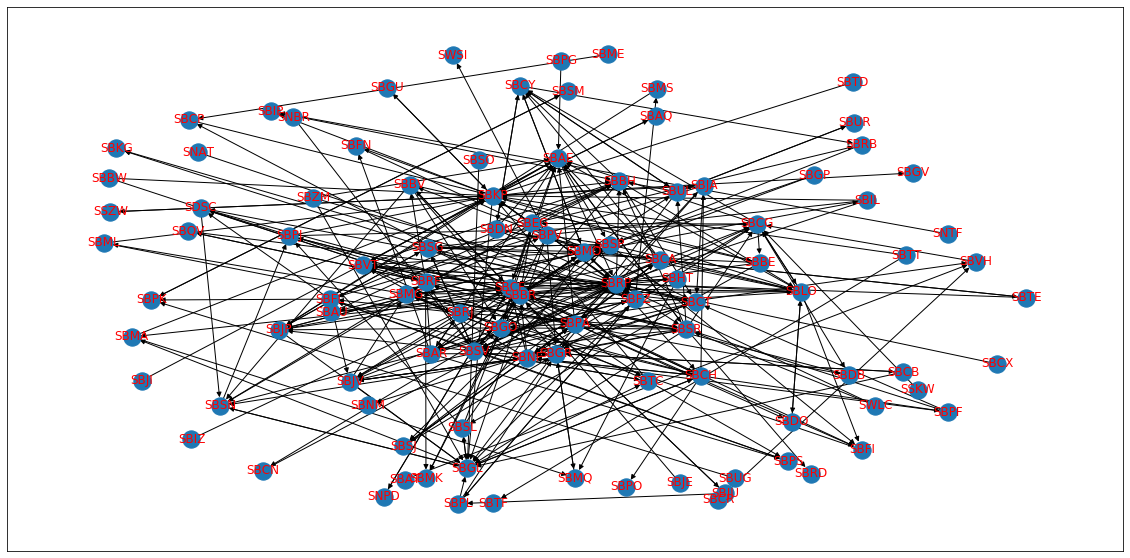

In [17]:
graph = nx.DiGraph()

graph.add_nodes_from(adjacency_list.keys())

for s in adjacency_list.keys():
    for d in adjacency_list[s]:
        graph.add_edge(s, d)
pos = nx.spring_layout(graph)

plt.figure(4,figsize=(20,10))

nx.draw_networkx(
    graph,
    pos=nx.spring_layout(graph,k=0.5,iterations=25),
    font_color='r'
)

### Árvore resultante pelo BFS
Na imagem é possível visualizar todos os nós que o BFS visitou. Em **verde** é o nó inicial, **vermelho** nó final e em **amarelo** os nós que o BFS passou até chegar no destino. As **arestas vermelhas** são as arestas utilizadas para chegar ao nó final.

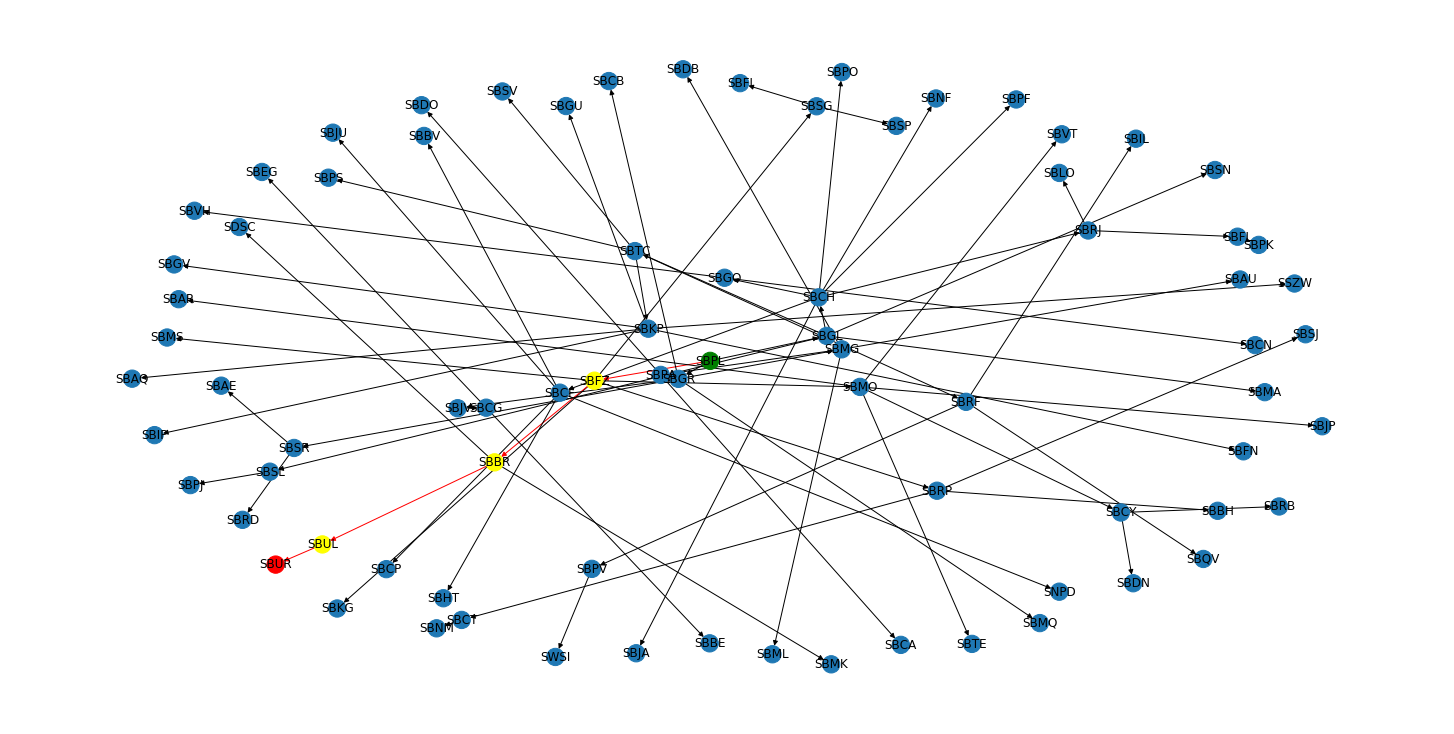

In [18]:
traversal_graph = nx.DiGraph()

traversal_graph.add_nodes_from(traversal_tree.keys())

edge_color = []

for s in traversal_tree.keys():
    for d in traversal_tree[s]:
        if s in path.keys() and path[s] == d:
            edge_color.append('r')
        else:
            edge_color.append('#000000')
        traversal_graph.add_edge(s, d)

color_map = []
for node in traversal_graph:
    if node == source:
        color_map.append('green')
    elif node == destiny: 
        color_map.append('red')  
    elif node in path.keys():
        color_map.append('yellow')  
    else:
        color_map.append('#1f78b4')
        
plt.figure(4,figsize=(20,10))   

nx.draw(traversal_graph, node_color=color_map, edge_color=edge_color, with_labels=True)

### Caminho percorrido do nó incial ao nó final

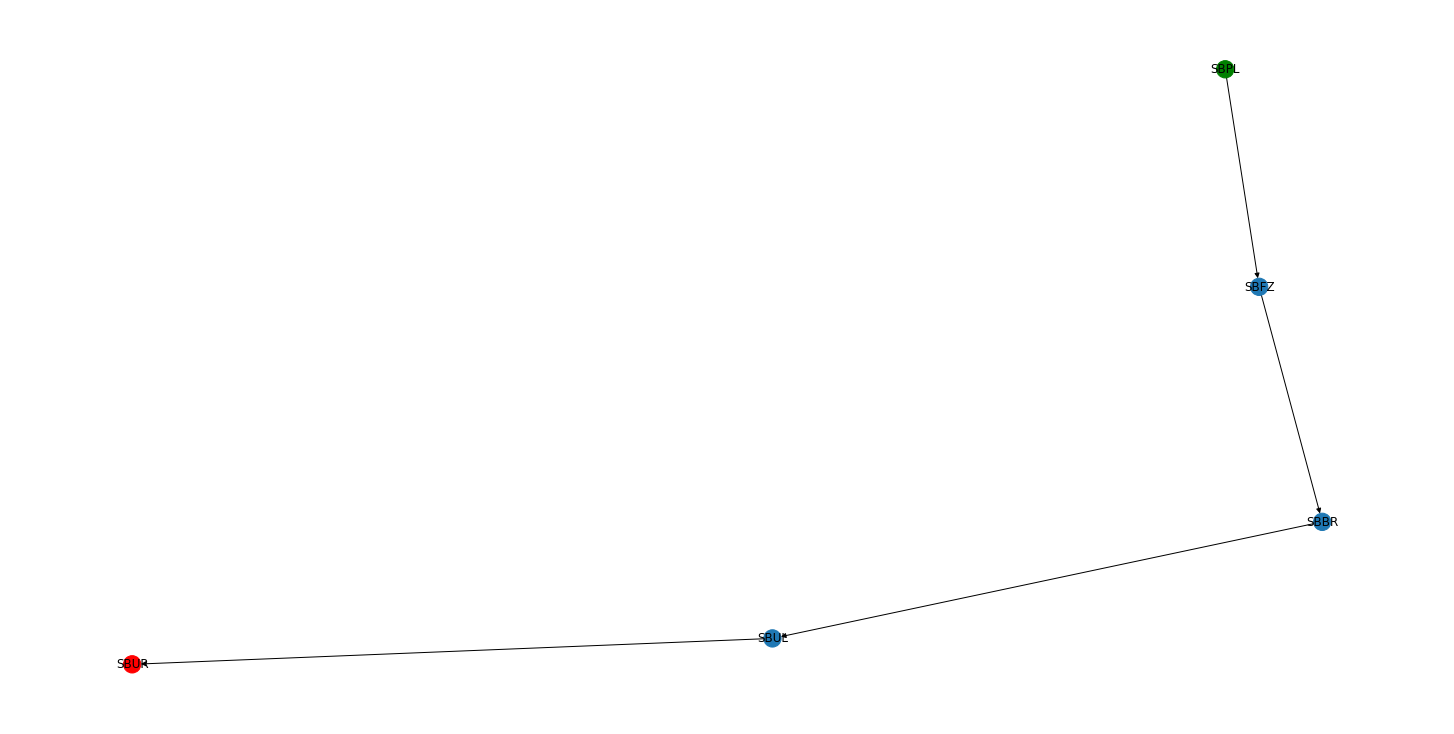

In [19]:
path_graph = nx.DiGraph()

path_graph.add_nodes_from(path.keys())

path_color_map = []
for node in path.keys():
    if node == source:
        path_color_map.append('green')
    else:
        path_color_map.append('#1f78b4')
        
path_color_map.append('red')  

for s in path.keys():
    path_graph.add_edge(s, path[s])

plt.figure(4,figsize=(20,10)) 
    
nx.draw(path_graph, node_color=path_color_map, with_labels=True)